<a href="https://colab.research.google.com/github/annisakumaladewi/ab_testing/blob/main/notebooks/A_B_Testing_Cookie_Cats_Automation_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
import os
od.download('https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats')

Skipping, found downloaded files in "./mobile-games-ab-testing-cookie-cats" (use force=True to force download)


In [4]:
os.listdir("mobile-games-ab-testing-cookie-cats")
df = pd.read_csv("mobile-games-ab-testing-cookie-cats/cookie_cats.csv", sep=",")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


* userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
* retention_1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

## 1. EDA

### Dealing with Missing Values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Dealing with Duplicates

In [11]:
print(len(df))
print(len(df.drop_duplicates(keep='first')))

90189
90189


no duplicates detected

### EDA Summary Stats

In [58]:
df.groupby('version')['sum_gamerounds'].agg({'mean', 'std','median'})

,std,mean,median
version,,,
gate_30,256.716423,52.456264,17.0
gate_40,103.294416,51.298776,16.0


In [59]:
df.groupby('version')['retention_1'].agg({'mean', 'std','median'})

,std,mean,median
version,,,
gate_30,0.497314,0.448188,0.0
gate_40,0.496663,0.442283,0.0


In [60]:
df.groupby('version')['retention_7'].agg({'mean', 'std','median'})

,std,mean,median
version,,,
gate_30,0.392464,0.190201,0.0
gate_40,0.385849,0.182000,0.0


### EDA: Confirm using Data Visualisation

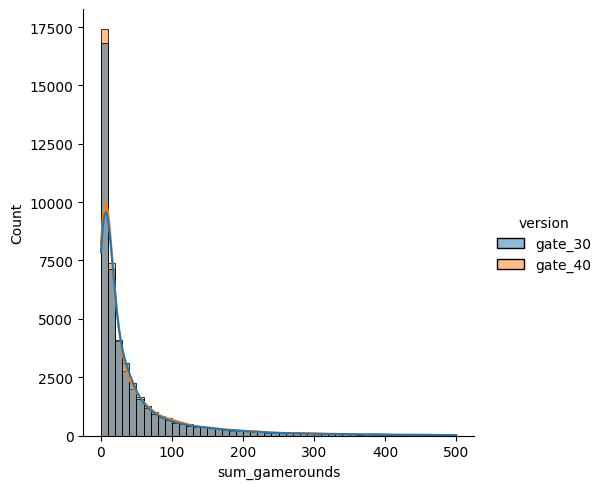

In [37]:
sns.displot(
    data=df[df["sum_gamerounds"] <= 500],
    x="sum_gamerounds",
    hue="version",
    bins=50,
    kde=True
)

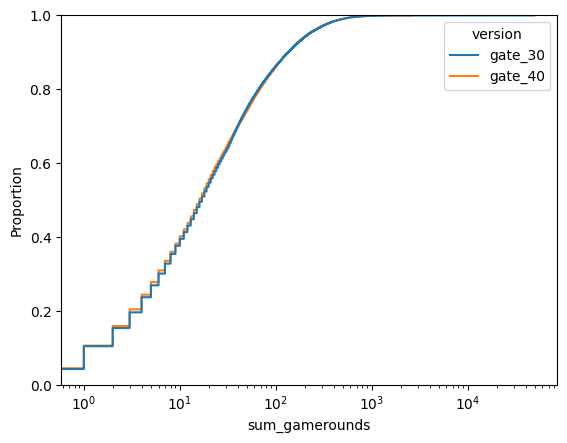

In [65]:
sns.ecdfplot(data=df, x="sum_gamerounds", hue="version")
plt.xscale("log")


## 2. Internal and External Validity Checks

| Component           | Example Question                               | Method                  |
| ------------------- | ---------------------------------------------- | ----------------------- |
| SRM                 | Did each group get equal users?                | Chi-square on counts    |
| Demographic Balance | Are attributes (browser/gender) balanced?      | Chi-square on crosstabs |
| A/A Test        | Do identical groups produce identical results? | Z-test on main metric   |


### Internal Validity: Sample Ratio Mismatch

In [6]:
import scipy.stats as stats
def srm_check(df, assign_col, expected_props=None, alpha=0.05):
    """
    Performs a Sample Ratio Mismatch (SRM) chi-square test.

    Parameters
    ----------
    df : pandas.DataFrame
        Experiment data containing the assignment column.
    assign_col : str
        Column name describing group assignment.
    expected_props : dict or None
        Expected allocation proportions per group.
        If None, equal split is assumed.
    alpha : float
        Significance threshold.

    Returns
    -------
    dict
        Contains observed counts, expected counts,
        chi-square statistic, p-value, and significance flag.
    """
    # all groups, fixed order
    groups = sorted(df[assign_col].unique())

    # observed counts in that order
    obs = df[assign_col].value_counts().reindex(groups).values
    n = len(df)
    k = len(groups)

    # --- expected counts ---
    if expected_props is None:
        # equal split
        expected = np.repeat(n / k, k)
    else:
        # assume dict like {"A": 0.5, "B": 0.3, "C": 0.2}
        props = np.array([expected_props[g] for g in groups], dtype=float)
        # normalise in case they don't sum exactly to 1
        props = props / props.sum()
        expected = props * n

    chi2, pval = stats.chisquare(obs, expected)

    return {
        "groups": groups,
        "observed": obs,
        "expected": expected,
        "chi2": chi2,
        "p_value": pval,
        "significant": pval < alpha
    }

In [7]:
srm_check(df, 'version')

# if users have specific proportions that is not equal split they can do so using the following example:
# srm_check(
#    checkout,
#    "checkout_page",
#    expected_props={"A": 0.5, "B": 0.3, "C": 0.2}
#)

{'groups': ['gate_30', 'gate_40'],
 'observed': array([44700, 45489]),
 'expected': array([45094.5, 45094.5]),
 'chi2': np.float64(6.9024049496058275),
 'p_value': np.float64(0.008607987810836262),
 'significant': np.True_}

SRM Check:

The sample ratio mismatch test revealed a statistically significant imbalance between gate_30 (44,700 players) and gate_40 (45,489 players) relative to the expected 1:1 split (p = 0.0086).

Given the dataset was preprocessed for teaching purposes, this imbalance likely results from data filtering or cleaning rather than a true randomization issue.

Nevertheless, the magnitude of mismatch (∼0.8%) is small relative to the total sample (90,189 players), so downstream analyses remain interpretable with appropriate caution.

### Internal Validity: Demographic Balance

In [1]:
from scipy import stats

def demographic_balance_tests(df, assign_col, covariates, dropna=False):
    """
    Chi-square balance checks for multiple covariates against the assignment column.

    Parameters
    ----------
    df : pd.DataFrame
    assign_col : str
        Column with variant assignment (e.g., 'checkout_page')
    covariates : list[str]
        Columns to test for balance (e.g., ['browser','gender'])
    dropna : bool
        If True, drop NA in covariate before testing; if False, NA is treated as a category.

    Returns
    -------
    pd.DataFrame with: covariate, chi2, dof, p_value, cramers_v, n_categories, min_expected, n_small_expected
    """
    rows = []
    for cov in covariates:
        sub = df[[assign_col, cov]].copy()
        if dropna:
            sub = sub.dropna(subset=[cov])
        # contingency table (NA as its own level if dropna=False)
        table = pd.crosstab(sub[assign_col], sub[cov], dropna=False)

        # chi-square test
        chi2, p, dof, expected = stats.chi2_contingency(table)
        n = table.values.sum()
        r, k = table.shape
        # Cramér's V (effect size)
        phi2 = chi2 / n
        cramers_v = np.sqrt(phi2 / max(1, min(r - 1, k - 1)))

        rows.append({
            "covariate": cov,
            "chi2": chi2,
            "dof": dof,
            "p_value": p,
            "cramers_v": cramers_v,
            "n_categories": k,
            "min_expected": float(expected.min()),
            "n_small_expected(<5)": int((expected < 5).sum())
        })
    return pd.DataFrame(rows).sort_values("p_value")



This dataset does not contain demographic or pre-treatment variables, so traditional demographic balance checks are not applicable. Instead, I rely on SRM checks and segment-based sensitivity analyses (e.g., random hashing-based segmentation) to ensure treatment effects are consistent.

### Internal Validity: A/A Testing

In [8]:
from statsmodels.stats.proportion import proportions_ztest

def a_a_test(df, assign_col, variant, outcome_col, alpha=0.05, random_state=42):
  """
    Performs an A/A test by randomly splitting a single variant into two
    pseudo-groups and comparing their outcome rates using a two-sample
    proportion z-test.

    A/A testing is used to validate experiment setup, randomization
    quality, and statistical testing pipelines. Since both groups come
    from the same underlying variant, their conversion rates should be
    statistically similar. A significant difference may indicate data
    quality issues, implementation errors, or unintended bias.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset containing experiment assignments and the outcome.
    assign_col : str
        Column name representing the experiment variant assignment
        (e.g., 'checkout_page').
    variant : str
        The specific variant label to extract and split into two subgroups
        (e.g., 'A').
    outcome_col : str
        Binary outcome variable used to compute conversion (e.g., 'purchased').
    alpha : float, optional (default=0.05)
        Significance threshold for the z-test.
    random_state : int, optional (default=42)
        Seed for reproducible random splitting.

    Returns
    -------
    dict
        Contains the statistical test results and group-level summaries:

        - 'variant' : the original variant selected for A/A splitting
        - 'groups' : list of generated subgroup names (e.g., ['A1', 'A2'])
        - 'z_stat' : z-statistic of the two-sample proportion test
        - 'p_value' : p-value corresponding to the z-statistic
        - 'alpha' : significance level used
        - 'significant' : boolean indicating if the test detects a difference
        - 'rates' : dictionary of conversion rates per subgroup
        - 'counts' : dictionary of number of successes per subgroup
        - 'nobs' : dictionary of subgroup sample sizes

    Notes
    -----
    - A non-significant result (p > alpha) suggests the A/A split behaves
      as expected.
    - A significant result (p < alpha) may indicate randomization issues,
      session contamination, or data pipeline inconsistencies.
    - This function assumes a binary outcome for the proportions z-test.
    """

  group = df[df[assign_col] == variant].copy()

  np.random.seed(random_state)
  group['aa_group'] = np.random.choice(['A1', 'A2'], size=len(group))

  AA_summary = group.groupby('aa_group')[outcome_col].agg(['sum', 'count'])

  count = AA_summary['sum'].values
  nobs = AA_summary['count'].values
  stat, pval = proportions_ztest(count, nobs)
  rates = (AA_summary['sum'] / AA_summary['count']).to_dict()

  return {
    "variant": variant,
    "groups": AA_summary.index.tolist(),      # like ['A1','A2']
    "z_stat": stat,
    "p_value": pval,
    "alpha": alpha,
    "significant": pval < alpha,
    "rates": rates,
    "counts": AA_summary['sum'].to_dict(),
    "nobs": AA_summary['count'].to_dict(),
}

In [9]:
a_a_test(df, 'version', 'gate_30', 'sum_gamerounds')

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:1024: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


{'variant': 'gate_30',
 'groups': ['A1', 'A2'],
 'z_stat': np.float64(nan),
 'p_value': np.float64(nan),
 'alpha': 0.05,
 'significant': np.False_,
 'rates': {'A1': 51.16801719120741, 'A2': 53.7430130125654},
 'counts': {'A1': 1142940, 'A2': 1201855},
 'nobs': {'A1': 22337, 'A2': 22363}}

p-value > 0.05 → Randomization and measurement pipeline look fine (A1 and A2 behave the same).

### External Validity: Simpson's paradox

In [10]:
def simpsons_check(df, assign_col, segment_col, outcome_col):
  def simpsons_check(df, assign_col, segment_col, outcome_col):
    """
    Detects potential Simpson's paradox in an A/B test by comparing the
    overall ordering of variants to the ordering within each segment.

    Simpson's paradox occurs when the relationship between variants
    (e.g., conversion rates) reverses or changes once the data is
    stratified by a third variable. This function checks for such
    pattern changes.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataset containing group assignments, segment values,
        and the outcome variable.
    assign_col : str
        Column name representing the experiment assignment
        (e.g., 'checkout_page', 'variant').
    segment_col : str
        Column name representing the subgroup or segment to stratify by
        (e.g., 'browser', 'gender', 'device').
    outcome_col : str
        Binary or numeric outcome variable used to compute conversion
        or average performance (e.g., 'purchased').

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row represents one segment value and
        includes:

        - 'segment' : segment identifier
        - 'overall_order' : overall ordering of variants by outcome
        - 'segment_order' : ordering of variants within that segment
        - 'pattern' : whether the segment matches, reverses, or differs
                      from the overall ordering
        - 'rates' : dictionary of variant outcome rates for that segment

        If any segment shows 'reversed_overall' or 'different_order',
        this indicates a potential Simpson's paradox effect.

    Notes
    -----
    This function does not assert causality; it simply identifies
    ranking inconsistencies that may warrant further investigation.
    """

  overall_rates = df.groupby(assign_col)[outcome_col].mean()
  overall_sorted = overall_rates.sort_values(ascending=False)
  overall_order = overall_sorted.index.tolist()

  segment_rates = (
      df.groupby([segment_col, assign_col])[outcome_col]
      .mean()
      .unstack(assign_col)
  )

  rows = []
  for seg_value, row in segment_rates.iterrows():
    seg_sorted = row.sort_values(ascending=False)
    seg_order = seg_sorted.index.tolist()

    if seg_order == overall_order:
        pattern = "same_as_overall"
    elif seg_order == overall_order[::-1]:
        pattern = "reversed_overall"
    else:
        pattern = "different_order"

    rows.append({
    "segment": seg_value,
    "overall_order": overall_order,
    "segment_order": seg_order,
    "pattern": pattern,
    # optional: include the actual rates for each variant
    "rates": row.to_dict(),
    })

  result = pd.DataFrame(rows)

  return result

In [62]:
df["segment"] = df["userid"] % 3

simpsons_check(
    df,
    assign_col="version",
    segment_col="segment",
    outcome_col="retention_1"
)

,segment,overall_order,segment_order,pattern,rates
0,0,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.4500066392245386, 'gate_40': 0.4..."
1,1,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.4447523146583767, 'gate_40': 0.4..."
2,2,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.4497675358803315, 'gate_40': 0.4..."


In [63]:
simpsons_check(
    df,
    assign_col="version",
    segment_col="segment",
    outcome_col="retention_7"
)

,segment,overall_order,segment_order,pattern,rates
0,0,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.19187358916478556, 'gate_40': 0...."
1,1,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.18855173345948503, 'gate_40': 0...."
2,2,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 0.19014891179839633, 'gate_40': 0...."


In [64]:
simpsons_check(
    df,
    assign_col="version",
    segment_col="segment",
    outcome_col="sum_gamerounds"
)

,segment,overall_order,segment_order,pattern,rates
0,0,"[gate_30, gate_40]","[gate_40, gate_30]",reversed_overall,"{'gate_30': 51.38587173018191, 'gate_40': 51.7..."
1,1,"[gate_30, gate_40]","[gate_40, gate_30]",reversed_overall,"{'gate_30': 51.284449550584576, 'gate_40': 51...."
2,2,"[gate_30, gate_40]","[gate_30, gate_40]",same_as_overall,"{'gate_30': 54.71093592076006, 'gate_40': 50.5..."


Since the dataset does not contain demographic or pre-treatment covariates, I used a hashed user segmentation (userid % 3) as a neutral pre-treatment bucketing method. This allowed me to perform a Simpson’s paradox consistency check without introducing bias.


For binary retention metrics (1-day and 7-day), the treatment effect remained consistent across all hashed user segments. This suggests that retention effects are stable and not driven by hidden subgroups.


For the continuous engagement metric (sum_gamerounds), Simpson’s paradox appeared in 2 of the 3 segments. This indicates that engagement is highly variable across users, and segment-level noise can reverse the observed effect direction. Such reversals are common in high-variance behavioral metrics and highlight the importance of validating treatment effects across user slices.

## 3. Experimental Design

### Dealing with Means

In [15]:
from statsmodels.stats.power import FTestAnovaPower

def anova_power_from_data(df, group_col, metric_col, alpha=0.05, power=0.8):
    """
    Estimate ANOVA effect size (Cohen's f) from data and
    compute required sample size per group.
    """
    # 1. split data by group
    groups = [g[metric_col].dropna().values
              for _, g in df.groupby(group_col)]

    k = len(groups)  # number of groups

    # 2. group means
    means = np.array([g.mean() for g in groups])

    # 3. pooled standard deviation (across all groups)
    n_list = [len(g) for g in groups]
    pooled_var = sum((n-1)*g.var(ddof=1) for g, n in zip(groups, n_list)) / (sum(n_list) - k)
    sd = np.sqrt(pooled_var)

    # 4. Cohen's f for ANOVA
    grand_mean = means.mean()
    f = np.sqrt(((means - grand_mean)**2).mean()) / sd

    # 5. power analysis
    analysis = FTestAnovaPower()
    n_per_group = analysis.solve_power(effect_size=f,
                                       alpha=alpha,
                                       power=power,
                                       k_groups=k)

    return {
        "metric": metric_col,
        "groups": k,
        "effect_size_f": f,
        "required_n_per_group": n_per_group,
        "total_required_n": n_per_group * k
    }


In [16]:
# Sample size for continuous
anova_power_from_data(df, "version", "sum_gamerounds")

{'metric': 'sum_gamerounds',
 'groups': 2,
 'effect_size_f': np.float64(0.0029671418683895937),
 'required_n_per_group': 891519.656028952,
 'total_required_n': 1783039.312057904}

### Dealing with Proportions

In [19]:
from itertools import combinations
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

def sample_size_proportion_multigroup(df, group_col, outcome_col, alpha=0.05, power=0.8):
    """
    Computes required sample size per group for detecting differences in proportions
    across 3+ variants in an A/B/n test.

    Parameters:
        df: dataframe
        group_col: column with A/B/C labels
        outcome_col: binary column (0/1)
        alpha: significance level
        power: desired power

    Returns:
        Dictionary with required sample sizes per pair + max needed
    """

    groups = df[group_col].unique()
    results = {}
    analysis = NormalIndPower()

    # Loop through all pairwise combinations (A-B, A-C, B-C)
    for g1, g2 in combinations(groups, 2):
        # Baseline proportion
        p1 = df[df[group_col] == g1][outcome_col].mean()
        # Treatment proportion
        p2 = df[df[group_col] == g2][outcome_col].mean()

        # Effect size (Cohen's h)
        h = proportion_effectsize(p1, p2)

        # Required sample size
        n = analysis.solve_power(effect_size=abs(h),
                                 power=power,
                                 alpha=alpha,
                                 alternative="two-sided")

        results[f"{g1} vs {g2}"] = n

    results["max_required_per_group"] = max(results.values())
    return results


In [20]:
sample_size_proportion_multigroup(
    df=df,
    group_col='version',
    outcome_col='retention_1',
    alpha=0.05,
    power=0.8
)

{'gate_30 vs gate_40': 111189.79968447058,
 'max_required_per_group': 111189.79968447058}

In [22]:
sample_size_proportion_multigroup(
    df=df,
    group_col='version',
    outcome_col='retention_7',
    alpha=0.05,
    power=0.8
)

{'gate_30 vs gate_40': 35346.19045088301,
 'max_required_per_group': 35346.19045088301}

## 4. Hypothesis Tests

### Analysing Difference in means A/B tests

In [23]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.2 MB/s eta 0:00:00


In [30]:
import pingouin

results_gamerounds = pingouin.pairwise_tests(data = df,
                                         dv = "sum_gamerounds",
                                         between = "version",
                                         padjust = "bonf",
                                         effsize="cohen")

print(results_gamerounds)

  Contrast        A        B  Paired  Parametric         T           dof  \
0  version  gate_30  gate_40   False        True  0.885437  58595.481423   

  alternative     p-unc   BF10     cohen  
0   two-sided  0.375924  0.011  0.005934  


### Analysis Difference in Proportions


In [25]:
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
import itertools

def pairwise_proportion_tests(df, group_col, outcome_col):

    grouped = df.groupby(group_col)
    successes = grouped[outcome_col].sum()
    nobs = grouped[outcome_col].count()
    p = successes / nobs
    groups = list(successes.index)

    results = []

    for g1, g2 in itertools.combinations(groups, 2):
        stat, pval = proportions_ztest([successes[g1], successes[g2]],
                                       [nobs[g1], nobs[g2]])
        h = proportion_effectsize(p[g1], p[g2])

        results.append({
            "comparison": f"{g1} vs {g2}",
            "p1": p[g1],
            "p2": p[g2],
            "z_stat": stat,
            "p_value": pval,
            "effect_size_h": h
        })

    return results


In [27]:
results_1 = pairwise_proportion_tests(df, 'version', 'retention_1')
results_1

[{'comparison': 'gate_30 vs gate_40',
  'p1': np.float64(0.4481879194630872),
  'p2': np.float64(0.44228274967574577),
  'z_stat': np.float64(1.7840862247974725),
  'p_value': np.float64(0.07440965529691913),
  'effect_size_h': np.float64(0.011881898259223478)}]

In [29]:
results_7 = pairwise_proportion_tests(df, 'version', 'retention_7')
results_7

[{'comparison': 'gate_30 vs gate_40',
  'p1': np.float64(0.19020134228187918),
  'p2': np.float64(0.18200004396667327),
  'z_stat': np.float64(3.164358912748191),
  'p_value': np.float64(0.001554249975614329),
  'effect_size_h': np.float64(0.021074001016365917)}]

In [ ]:
# apply FWER bonferroni correction as it tests more than once - 3 pairwise tests

def add_bonferroni(results, alpha=0.05):
    m = len(results)                  # number of pairwise comparisons
    alpha_bonf = alpha / m            # adjusted significance threshold

    for r in results:
        p = r["p_value"]
        r["p_bonf"] = min(p * m, 1.0) # Bonferroni corrected p-value
        r["alpha_bonf"] = alpha_bonf  # store threshold for reference
        r["significant"] = r["p_bonf"] < alpha_bonf

    return results

results_bonf = add_bonferroni(results)

for r in results_bonf:
    print(r["comparison"],
          "| original p:", round(r["p_value"], 5),
          "| p_bonf:", round(r["p_bonf"], 5),
          "| alpha_bonf:", round(r["alpha_bonf"], 5),
          "| significant?", r["significant"])


A vs B | original p: 0.00555 | p_bonf: 0.01664 | alpha_bonf: 0.01667 | significant? True
A vs C | original p: 0.0 | p_bonf: 0.0 | alpha_bonf: 0.01667 | significant? True
B vs C | original p: 0.0221 | p_bonf: 0.0663 | alpha_bonf: 0.01667 | significant? False


## 6. Delta Test

The next two functions were inspired by: https://medium.com/@ahmadnuraziz3/applying-delta-method-for-a-b-tests-analysis-8b1d13411c22

In [39]:
from scipy.stats import norm

def var_delta(x, y):
    """
    Delta-method variance of a ratio-of-means metric: E[X]/E[Y]
    x, y are per-user numerator and denominator arrays for ONE variant.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    x_bar = np.mean(x)
    y_bar = np.mean(y)
    x_var = np.var(x, ddof=1)
    y_var = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]

    # Same formula as in the slides / Medium article
    var_ratio = (
        x_var / y_bar**2
        + y_var * (x_bar**2 / y_bar**4)
        - 2 * cov_xy * (x_bar / y_bar**3)
    ) / len(x)

    return var_ratio


In [40]:
def ztest_delta(x_control, y_control, x_treatment, y_treatment, alpha=0.05):
    x_control = np.asarray(x_control, dtype=float)
    y_control = np.asarray(y_control, dtype=float)
    x_treatment = np.asarray(x_treatment, dtype=float)
    y_treatment = np.asarray(y_treatment, dtype=float)

    mean_control = x_control.sum() / y_control.sum()
    mean_treatment = x_treatment.sum() / y_treatment.sum()

    var_control = var_delta(x_control, y_control)
    var_treatment = var_delta(x_treatment, y_treatment)

    var_diff = var_control + var_treatment
    se = np.sqrt(var_diff)

    diff = mean_treatment - mean_control
    z_stat = diff / se

    p_value = 2 * (1 - norm.cdf(abs(z_stat)))

    z_crit = norm.ppf(1 - alpha / 2)
    lower = diff - z_crit * se
    upper = diff + z_crit * se

    return {
        "mean_control": mean_control,
        "mean_treatment": mean_treatment,
        "var_control": var_control,
        "var_treatment": var_treatment,
        "diff": diff,
        "diff_CI": (lower, upper),
        "z_stat": z_stat,
        "p_value": p_value,
    }


In [47]:
def pairwise_delta_test(df, col_var, num_col, denom_col, user_col):
    groups = df[col_var].unique()
    results = []

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            g1 = groups[i]
            g2 = groups[j]

            df1 = df[df[col_var] == g1]
            df2 = df[df[col_var] == g2]

            per_user_1 = df1.groupby(user_col)[[num_col, denom_col]].sum()
            per_user_2 = df2.groupby(user_col)[[num_col, denom_col]].sum()

            x_control = per_user_1[num_col].values
            y_control = per_user_1[denom_col].values

            x_treatment = per_user_2[num_col].values
            y_treatment = per_user_2[denom_col].values

            delta_res = ztest_delta(x_control, y_control, x_treatment, y_treatment)

            # here adapt to how ztest_delta returns results
            diff = delta_res['diff']
            pval = delta_res['p_value']

            results.append({
                "comparison": f"{g1} vs {g2}",
                "diff": diff,
                "p_value": pval
            })

    return results


In [48]:
df["days"] = 14

pairwise_ratio = pairwise_delta_test(
    df=df,
    col_var='version',
    num_col='sum_gamerounds',
    denom_col='days',
    user_col='userid'
)
pairwise_ratio

[{'comparison': 'gate_30 vs gate_40',
  'diff': np.float64(-0.08267774671094585),
  'p_value': np.float64(0.3759207506069564)}]

## 7. Summary

In [49]:
def combine_results(result_tables, test_types, alpha=0.05):
    """
    Combine multiple result tables (means, proportions, delta, etc.)
    into one standardized summary.

    Parameters
    ----------
    result_tables : list of pd.DataFrame
        Each table must at least have columns:
        - 'comparison'
        - 'p_value'
        - 'effect_size'
        Optionally:
        - 'metric' (e.g. 'order_value', 'purchased', 'ratio_metric')
    test_types : list of str
        Label for each table, same length as result_tables.
        Examples: 'mean', 'proportion', 'delta'
    alpha : float
        Significance threshold, default 0.05.

    Returns
    -------
    pd.DataFrame
        Combined table with columns:
        - comparison
        - metric (if present in inputs)
        - p_value
        - effect_size
        - test_type
        - significant
        - effect_size_label
    """
    if len(result_tables) != len(test_types):
        raise ValueError("result_tables and test_types must have the same length")

    all_tables = []

    for table, ttype in zip(result_tables, test_types):
        tmp = table.copy()

        # add which kind of test this came from
        tmp["test_type"] = ttype

        # significance flag
        tmp["significant"] = tmp["p_value"] < alpha

        # interpret effect size (if present)
        if "effect_size" in tmp.columns:
            if ttype in ["mean", "proportion"]:
                es_abs = tmp["effect_size"].abs()

                conditions = [
                    es_abs < 0.1,
                    (es_abs >= 0.1) & (es_abs < 0.3),
                    (es_abs >= 0.3) & (es_abs < 0.5),
                    es_abs >= 0.5,
                ]
                labels = [
                    "very small",
                    "small",
                    "medium",
                    "large",
                ]
                tmp["effect_size_label"] = np.select(
                    conditions, labels, default="unknown"
                )

            elif ttype == "delta":
                # raw difference on ratio metric – interpretation is context-specific
                tmp["effect_size_label"] = "raw_diff"

            else:
                tmp["effect_size_label"] = "unknown"
        else:
            tmp["effect_size_label"] = "missing"

        all_tables.append(tmp)

    combined = pd.concat(all_tables, ignore_index=True)

    # nice ordering if 'metric' exists
    sort_cols = ["metric", "comparison"] if "metric" in combined.columns else ["comparison"]
    combined = combined.sort_values(sort_cols)

    return combined


In [51]:
df_ret1 = pd.DataFrame(results_1)

df_ret1 = df_ret1[["comparison", "p_value", "effect_size_h"]]
df_ret1 = df_ret1.rename(columns={"effect_size_h": "effect_size"})
df_ret1["metric"] = "retention_1"
df_ret1["test_type"] = "proportion"


In [53]:
df_ret7 = pd.DataFrame(results_7)

df_ret7 = df_ret7[["comparison", "p_value", "effect_size_h"]]
df_ret7 = df_ret7.rename(columns={"effect_size_h": "effect_size"})
df_ret7["metric"] = "retention_7"
df_ret7["test_type"] = "proportion"


In [54]:
df_rounds = results_gamerounds.copy()

df_rounds = df_rounds.rename(columns={
    "p-unc": "p_value",
    "cohen": "effect_size"
})

df_rounds["comparison"] = df_rounds["A"] + " vs " + df_rounds["B"]
df_rounds = df_rounds[["comparison", "p_value", "effect_size"]]

df_rounds["metric"] = "sum_gamerounds"
df_rounds["test_type"] = "mean"


In [55]:
df_delta = pd.DataFrame(pairwise_ratio)
df_delta = df_delta.rename(columns={"diff": "effect_size"})

df_delta["metric"] = "ratio_gamerounds"
df_delta["test_type"] = "delta"


In [57]:
combined_display = combine_results(
    [df_ret1, df_ret7, df_rounds, df_delta],
    ["proportion","proportion","mean","delta"],
    alpha=0.05
)
combined_display

,comparison,p_value,effect_size,metric,test_type,significant,effect_size_label
3,gate_30 vs gate_40,0.375921,-0.082678,ratio_gamerounds,delta,False,raw_diff
0,gate_30 vs gate_40,0.074410,0.011882,retention_1,proportion,False,very small
1,gate_30 vs gate_40,0.001554,0.021074,retention_7,proportion,True,very small
2,gate_30 vs gate_40,0.375924,0.005934,sum_gamerounds,mean,False,very small
